# 1. Introdução
O notebook abaixo apresenta e implementa o spot-checking de modelos preditivos supervisionados, desenvolvido para primeiro trabalho da disciplina Aprendizado de Máquina da Universidade Federal do Rio Grande do Sul (2024/2).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset carregado nesse notebook, analisamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.


## Setup

In [1]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost optuna hyperopt setuptools nbformat

In [2]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_contour, plot_parallel_coordinate, plot_param_importances
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

c:\Users\Matheus\source\repos\ipp-student-dropout\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Carregamento dos dados

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [3]:
data = pd.read_csv("../data/clean-dataset.csv")

In [4]:
# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

In [5]:
# Algoritmos selecionados para treinamento
dtree = DecisionTreeClassifier(random_state=0)
dtree2 = DecisionTreeClassifier(random_state=0, max_depth=10)
rfc_gini = RandomForestClassifier(random_state=2)
rfc_entropy = RandomForestClassifier(random_state=2, criterion='entropy')
lr = LogisticRegression(random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0, algorithm='SAMME')
svmachine = svm.SVC(kernel='linear',probability=True)

algo_dict = {'Decision Tree': dtree, 'Decision Tree Max depth 5': dtree2, 'Random Forest gini': rfc_gini, 'Random Forest entropy': rfc_entropy, 'Logistic Regression': lr, '3-Nearest Neighbors': knn_3, '5-Nearest Neighbors': knn_5, 'AdaBoost': abc, 'SVM': svmachine}

In [6]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=10, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

In [7]:
# def define_grid_search_params(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__max_depth': [10, 20, 30]
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': [5, 10, 20, 30]
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10, 100]
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': [3, 5, 7, 10]
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__learning_rate': [0.01, 0.1, 1]
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10],
#             'Modelo__kernel': ['linear', 'rbf']
#         }
#     else:
#         raise ValueError(f"Não foi definido parâmetro para o modelo: {model_name}")

In [8]:
# def nested_cv_with_gridsearch(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():
#         param_grid = define_grid_search_params(model_name)

#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             pipeline = make_pipeline(model)

#             grid_search = GridSearchCV(
#                 estimator=pipeline,
#                 param_grid=param_grid,
#                 cv=StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42),
#                 scoring=metric,
#                 n_jobs=-1
#             )

#             grid_search.fit(X_train, y_train)

#             best_pipeline = grid_search.best_estimator_
#             y_pred = best_pipeline.predict(X_test)

#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [9]:
# results_df = nested_cv_with_gridsearch(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [10]:
# def define_hyperopt_space(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'n_neighbors': hp.quniform('n_neighbors', 3, 20, 1),
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(2)),
#         }
#     elif model_name == 'SVM':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#             'kernel': hp.choice('kernel', ['linear', 'rbf']),
#         }

In [11]:
# def nested_cv_with_hyperopt(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():

#         # Define objective function for Hyperopt
#         def objective(params):
#             # If SVM, map the kernel index to string for correct cross-validation
#             if 'kernel' in params and model_name == 'SVM':
#                 kernel_mapping = ['linear', 'rbf']
#                 if isinstance(params['kernel'], int):
#                     params['kernel'] = kernel_mapping[params['kernel']]

#             pipeline = make_pipeline(model)

#             # Convert integer-like floats to int
#             final_params = {}
#             for k, v in params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)  # Convert to int if it is a whole number float
#                 final_params[f'Modelo__{k}'] = v

#             pipeline.set_params(**final_params)

#             inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
#             scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1)
#             return {'loss': -np.mean(scores), 'status': STATUS_OK}

#         # Outer loop
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             search_space = define_hyperopt_space(model_name)
#             trials = Trials()

#             best_params = fmin(
#                 fn=objective,
#                 space=search_space,
#                 algo=tpe.suggest,
#                 max_evals=20,
#                 trials=trials,
#             )

#             # Map SVM kernel back if needed
#             if model_name == 'SVM' and 'kernel' in best_params:
#                 kernel_mapping = ['linear', 'rbf']
#                 best_params['kernel'] = kernel_mapping[best_params['kernel']]

#             # Convert parameters and retrain pipeline
#             final_params = {}
#             for k, v in best_params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)
#                 final_params[f'Modelo__{k}'] = v

#             # Train the pipeline with the best parameters
#             pipeline = make_pipeline(model)
#             pipeline.set_params(**final_params)
#             pipeline.fit(X_train, y_train)

#             # Evaluate on the test set
#             y_pred = pipeline.predict(X_test)
#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [12]:
# results_df = nested_cv_with_hyperopt(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [13]:
# def define_optuna_space(model_name, trial):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': trial.suggest_int('n_neighbors', 3, 20)
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
#             'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
#             'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
#         }

In [14]:
def define_optuna_space(model_name, trial):
    
    # Define o espaço de busca de hiperparâmetros para cada tipo de modelo
    if model_name == 'Logistic Regression':

        # Caso a gente queira fazer uma avaliação mais simples:
        # # Para regressão logística, ajusta o parâmetro de regularização C
        # return {
        #     'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
        # }

        # Senão, com mais hiperparâmetros:
        solver_penalty_str = trial.suggest_categorical(
            'solver_penalty',
            ['liblinear_l1', 'liblinear_l2', 'lbfgs_l2']
        )

        # Quebra as strings de maneira a ter o solver e a penalidade certa
        solver, penalty = solver_penalty_str.split('_')

        return {
            'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'Modelo__solver': solver,
            'Modelo__penalty': penalty
        }

    elif model_name == 'AdaBoost':
        # Para AdaBoost, ajusta o número de estimadores e a taxa de aprendizado
        return {
            'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
        }
    elif model_name == 'SVM':
        # Para SVM, ajusta o parâmetro C e o tipo de kernel
        return {
            'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
        }
    else:
        # Se nenhum hiperparâmetro estiver definido no modelo, retorna um dicionário vazio
        return {}

In [15]:
def objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric):
    # Define o espaço de busca dos hiperparâmetros
    params = define_optuna_space(model_name, trial)

    # Cria o pipeline com seleção de atributos, normalização, balanceamento e o modelo
    pipeline = make_pipeline(model)

    # Ajusta o pipeline com os hiperparâmetros sugeridos pelo trial do optuna
    pipeline.set_params(**params)

    # Define o k-fold interno para validação cruzada
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)

    # Calcula a métrica de avaliação média (por ex. F1) através de validação cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1).mean()
    return score


In [16]:
# Executa o estudo do Optuna para um único fold externo e retorna o melhor estudo
def run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20):

    # Função objetivo que o Optuna irá otimizar
    def objective(trial):
        return objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric)

    # Cria o estudo do Optuna com objetivo de maximizar a métrica
    study = optuna.create_study(direction="maximize")

    # Executa o estudo com número definido de tentativas (n_trials)
    study.optimize(objective, n_trials=n_trials)
    return study

In [17]:
# Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
def evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(model)
    pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return {
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }

In [18]:
def nested_cv_with_optuna(X, y, models, outer_folds=4, inner_folds=2, metric='f1'):

    # Define o k-fold externo para a nested cv
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []
    best_study_per_model = {}
    best_params_per_model = {}
    best_f1_per_model = {}
    all_fold_params_per_model = {}

    # Loop pelos modelos que serão ajustados
    for model_name, model in models.items():
        # Vamos armazenar o melhor estudo e parâmetros por conveniência, 
        # mas não iremos basear a escolha dos parâmetros no conjunto de teste.
        studies = []
        fold_params = []
        fold_test_metrics = []

        # Loop do k-fold externo
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Executa o estudo do Optuna para o fold atual
            study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20)
            studies.append(study)  # Append the study to the list

            # Obtém os melhores parâmetros do estudo
            fold_best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

            # Retira os pares de strings solver_penalty, caso presentes
            if 'Modelo__solver_penalty' in fold_best_params:
                del fold_best_params['Modelo__solver_penalty']

            # Avalia no conjunto de teste com os melhores parâmetros
            metrics = evaluate_best_params(model, fold_best_params, X_train, y_train, X_test, y_test)
            metrics['Model'] = model_name
            results.append(metrics)

            fold_params.append(fold_best_params)
            fold_test_metrics.append(metrics['F1 Score'])

        # Aqui, best_study_per_model, best_params_per_model, e best_f1_per_model não usam o conjunto de teste para escolha,
        # mas iremos apenas reportar os melhores resultados encontrados internamente.
        # Como cada fold externo produz seu próprio conjunto de parâmetros, 
        # não há um único "melhor" conjunto global, pois cada outer fold é independente.
        # Podemos, por exemplo, escolher o primeiro estudo ou o estudo com melhor média interna.
        best_study_per_model[model_name] = studies[0]
        best_params_per_model[model_name] = fold_params[0]  # por exemplo, o primeiro fold
        best_f1_per_model[model_name] = sum(fold_test_metrics) / len(fold_test_metrics)

        all_fold_params_per_model[model_name] = fold_params

    # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
    return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model

In [19]:
optuna_algo_dict = {
    'Logistic Regression': algo_dict['Logistic Regression'],
    'AdaBoost': algo_dict['AdaBoost'],
    'SVM': algo_dict['SVM']
}

# Executa a validação cruzada aninhada com otimização de hiperparâmetros via Optuna
results_df, best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model = nested_cv_with_optuna(X, y, optuna_algo_dict, outer_folds=5, inner_folds=3, metric='f1')
display(results_df)

[I 2024-12-11 13:35:22,037] A new study created in memory with name: no-name-d0583cfc-2c23-487f-b9f0-e0cbfc1f759b
[I 2024-12-11 13:35:23,419] Trial 0 finished with value: 0.7441015042688711 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 77.26456914816005}. Best is trial 0 with value: 0.7441015042688711.
[I 2024-12-11 13:35:24,164] Trial 1 finished with value: 0.7437527537384141 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 50.00525427142602}. Best is trial 0 with value: 0.7441015042688711.
[I 2024-12-11 13:35:24,887] Trial 2 finished with value: 0.7429099543102667 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 0.918244224790964}. Best is trial 0 with value: 0.7441015042688711.
[I 2024-12-11 13:35:25,589] Trial 3 finished with value: 0.739922902675317 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 0.09211909415054845}. Best is trial 0 with value: 0.7441015042688711.
[I 2024-12-11 13:35:26,292] Trial 4 finished with value: 0.7437013637269949 and parameters: {

,F1 Score,Precision,Recall,ROC AUC,Model
0,0.716522,0.710345,0.722807,0.870512,Logistic Regression
1,0.750000,0.750000,0.750000,0.881210,Logistic Regression
2,0.762411,0.767857,0.757042,0.892907,Logistic Regression
3,0.736283,0.740214,0.732394,0.880405,Logistic Regression
4,0.737968,0.747292,0.728873,0.875478,Logistic Regression
5,0.728843,0.717687,0.740351,0.880374,AdaBoost
6,0.732496,0.747253,0.718310,0.875706,AdaBoost
7,0.756477,0.742373,0.771127,0.897433,AdaBoost
8,0.740870,0.731959,0.750000,0.892694,AdaBoost
9,0.741135,0.746429,0.735915,0.879442,AdaBoost


In [20]:
for model_name in best_params_per_model:
    print(f"Best parameters for {model_name}: {best_params_per_model[model_name]}")

Best parameters for Logistic Regression: {'Modelo__C': 77.26456914816005}
Best parameters for AdaBoost: {'Modelo__n_estimators': 156, 'Modelo__learning_rate': 0.4067287601566914}
Best parameters for SVM: {'Modelo__C': 0.0005115218338181281, 'Modelo__kernel': 'linear'}


In [21]:
for model_name, fold_params_list in all_fold_params_per_model.items():
    for fold_idx, fold_params in enumerate(fold_params_list, start=1):
        print(f"Parameters for {model_name}, Fold {fold_idx}: {fold_params}")

Parameters for Logistic Regression, Fold 1: {'Modelo__C': 77.26456914816005}
Parameters for Logistic Regression, Fold 2: {'Modelo__C': 0.04500154865920343}
Parameters for Logistic Regression, Fold 3: {'Modelo__C': 0.02446128294575711}
Parameters for Logistic Regression, Fold 4: {'Modelo__C': 370.0883749511317}
Parameters for Logistic Regression, Fold 5: {'Modelo__C': 246.3671280415149}
Parameters for AdaBoost, Fold 1: {'Modelo__n_estimators': 156, 'Modelo__learning_rate': 0.4067287601566914}
Parameters for AdaBoost, Fold 2: {'Modelo__n_estimators': 141, 'Modelo__learning_rate': 1.4943603171524553}
Parameters for AdaBoost, Fold 3: {'Modelo__n_estimators': 423, 'Modelo__learning_rate': 0.5709728246385414}
Parameters for AdaBoost, Fold 4: {'Modelo__n_estimators': 367, 'Modelo__learning_rate': 0.7583720923018442}
Parameters for AdaBoost, Fold 5: {'Modelo__n_estimators': 189, 'Modelo__learning_rate': 0.5635550598490047}
Parameters for SVM, Fold 1: {'Modelo__C': 0.0005115218338181281, 'Model

In [22]:
best_study = best_study_per_model[model_name]
print(best_study.best_params)  # Dictionary of best hyperparameters

{'C': 0.0005115218338181281, 'kernel': 'linear'}


In [23]:
# Exibe os melhores resultados e parâmetros para cada modelo
for model_name in best_study_per_model:
    print(f"Best F1 for {model_name}: {best_f1_per_model[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params_per_model[model_name]}")

    print(f"Plots for model: {model_name}")

    study = best_study_per_model[model_name]
    fig_opt_history = plot_optimization_history(study)
    fig_opt_history.show()

    fig_slice = plot_slice(study)
    fig_slice.show()

    fig_parallel = plot_parallel_coordinate(study)
    fig_parallel.show()

    fig_contour = plot_contour(study)
    fig_contour.show()

    fig_param_importances = plot_param_importances(study)
    fig_param_importances.show()

Best F1 for Logistic Regression: 0.7406368373854753
Best Parameters for Logistic Regression: {'Modelo__C': 77.26456914816005}
Plots for model: Logistic Regression


Best F1 for AdaBoost: 0.7399638690135399
Best Parameters for AdaBoost: {'Modelo__n_estimators': 156, 'Modelo__learning_rate': 0.4067287601566914}
Plots for model: AdaBoost


Best F1 for SVM: 0.7332160889763739
Best Parameters for SVM: {'Modelo__C': 0.0005115218338181281, 'Modelo__kernel': 'linear'}
Plots for model: SVM


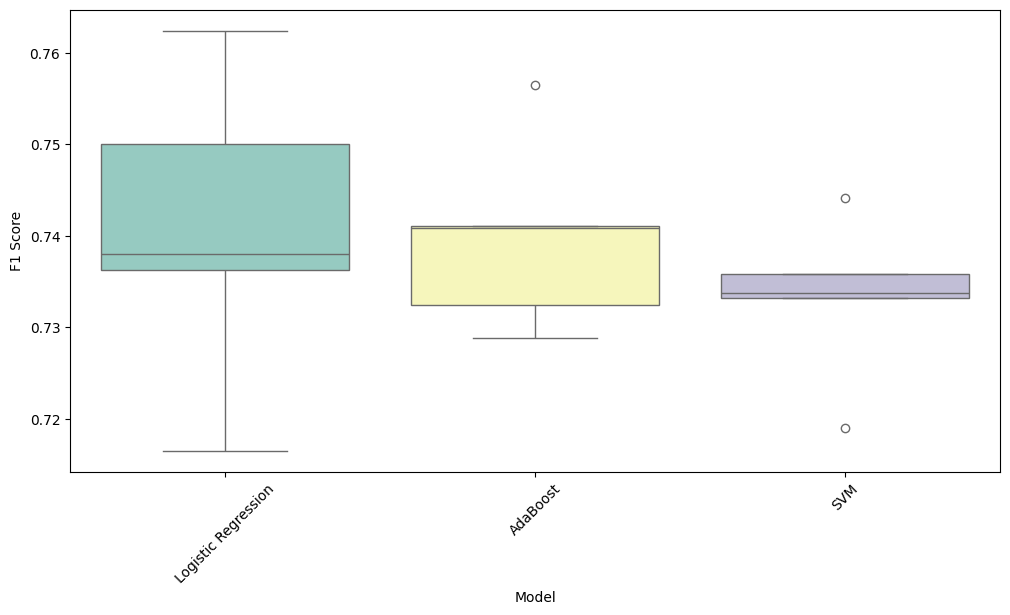

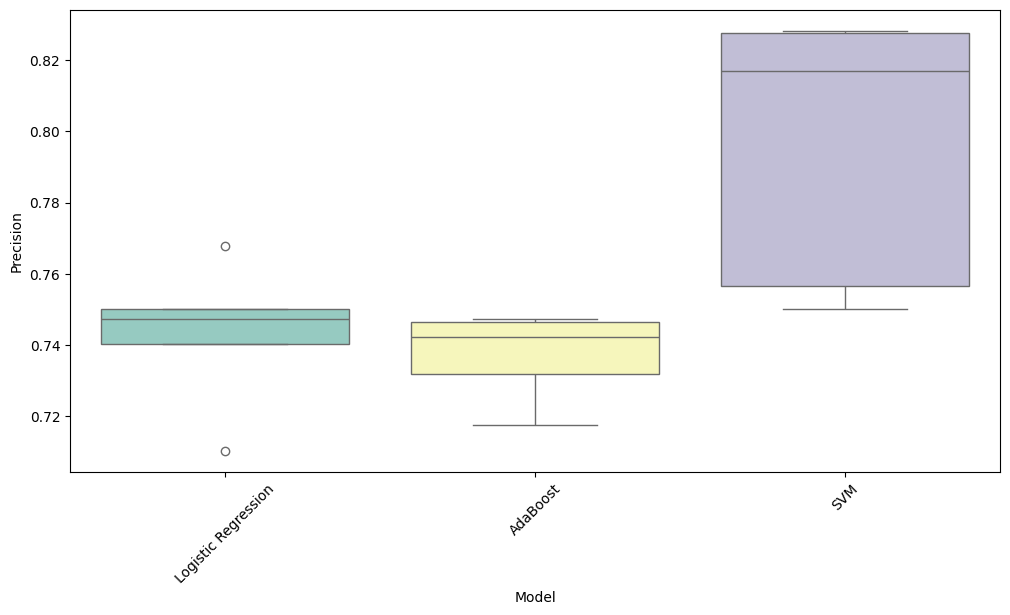

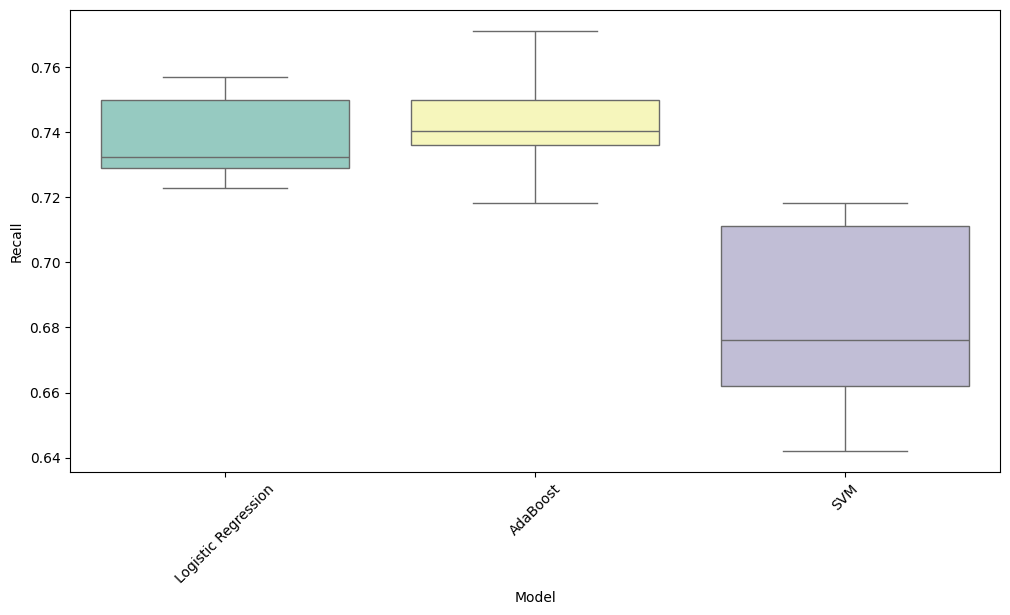

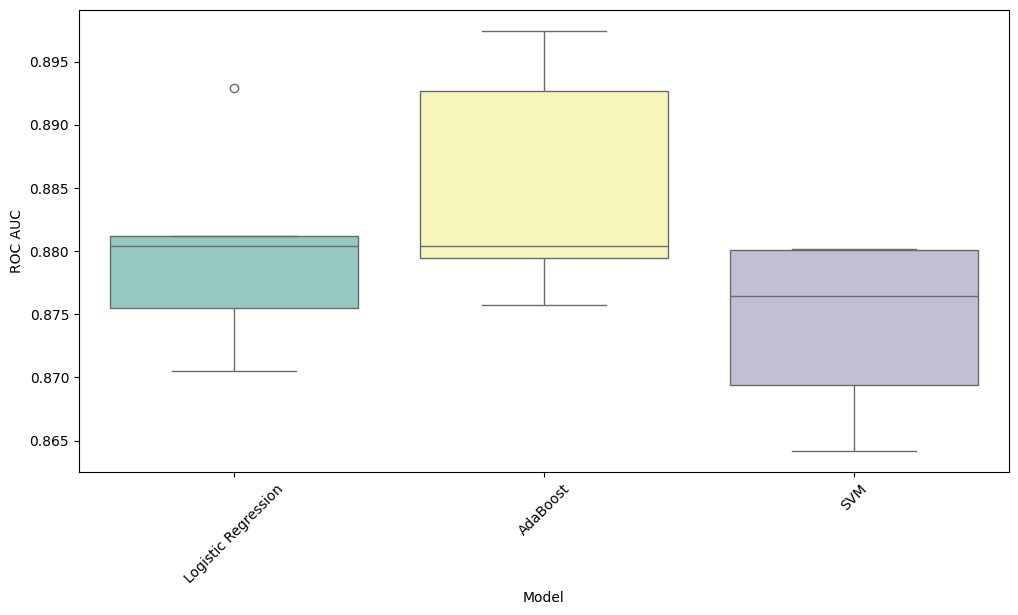

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot de F1
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='F1 Score', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da precisão
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Precision', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot do recall
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Recall', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da ROC AUC
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='ROC AUC', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Load the dataset
data = pd.read_csv("../data/clean-dataset.csv")

X = data.drop('Target', axis=1)
y = data['Target']

# Split into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

# Define a function to create the pipeline
def make_pipeline():
    steps = [
        ('Feature Selection', SelectKBest(k=10, score_func=mutual_info_classif)),
        ('Normalização', StandardScaler()),
        ('Balanceamento', SMOTE(sampling_strategy='minority', random_state=42)),
        ('Modelo', AdaBoostClassifier(random_state=0, algorithm='SAMME'))
    ]
    pipe = Pipeline(steps=steps)
    return pipe

# Define the objective function for Optuna
def objective(trial):
    # Define the search space for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 2.0, log=True)
    
    # Create the pipeline with the suggested hyperparameters
    pipeline = make_pipeline()
    pipeline.set_params(Modelo__n_estimators=n_estimators,
                        Modelo__learning_rate=learning_rate)
    
    # Use cross-validation on the entire training set to evaluate the candidate parameters
    # We'll use StratifiedKFold for a stable estimate of performance.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    return scores.mean()

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', study_name='AdaBoost_Optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print the best parameters found by Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_pipeline = make_pipeline()
best_pipeline.set_params(Modelo__n_estimators=best_params['n_estimators'],
                         Modelo__learning_rate=best_params['learning_rate'])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

[I 2024-12-11 13:38:00,794] A new study created in memory with name: AdaBoost_Optimization
Best trial: 0. Best value: 0.692516:   2%|▏         | 1/50 [00:00<00:24,  1.98it/s]

[I 2024-12-11 13:38:01,301] Trial 0 finished with value: 0.6925160517573703 and parameters: {'n_estimators': 278, 'learning_rate': 0.01389186261044391}. Best is trial 0 with value: 0.6925160517573703.


Best trial: 1. Best value: 0.740972:   4%|▍         | 2/50 [00:01<00:27,  1.76it/s]

[I 2024-12-11 13:38:01,913] Trial 1 finished with value: 0.7409724424603483 and parameters: {'n_estimators': 398, 'learning_rate': 0.18905950356506704}. Best is trial 1 with value: 0.7409724424603483.


Best trial: 1. Best value: 0.740972:   6%|▌         | 3/50 [00:01<00:28,  1.63it/s]

[I 2024-12-11 13:38:02,578] Trial 2 finished with value: 0.735451865532635 and parameters: {'n_estimators': 437, 'learning_rate': 0.1028688348383251}. Best is trial 1 with value: 0.7409724424603483.


Best trial: 3. Best value: 0.742682:   8%|▊         | 4/50 [00:02<00:29,  1.54it/s]

[I 2024-12-11 13:38:03,282] Trial 3 finished with value: 0.7426815832713553 and parameters: {'n_estimators': 478, 'learning_rate': 1.1092046670237456}. Best is trial 3 with value: 0.7426815832713553.


Best trial: 3. Best value: 0.742682:  10%|█         | 5/50 [00:03<00:30,  1.45it/s]

[I 2024-12-11 13:38:04,038] Trial 4 finished with value: 0.7337365972176003 and parameters: {'n_estimators': 493, 'learning_rate': 0.0520092981393902}. Best is trial 3 with value: 0.7426815832713553.


Best trial: 3. Best value: 0.742682:  12%|█▏        | 6/50 [00:03<00:28,  1.55it/s]

[I 2024-12-11 13:38:04,607] Trial 5 finished with value: 0.7411204049006901 and parameters: {'n_estimators': 368, 'learning_rate': 0.1530841758655434}. Best is trial 3 with value: 0.7426815832713553.


Best trial: 3. Best value: 0.742682:  14%|█▍        | 7/50 [00:04<00:26,  1.64it/s]

[I 2024-12-11 13:38:05,144] Trial 6 finished with value: 0.7250108682169888 and parameters: {'n_estimators': 325, 'learning_rate': 0.025955788177418476}. Best is trial 3 with value: 0.7426815832713553.


Best trial: 3. Best value: 0.742682:  16%|█▌        | 8/50 [00:04<00:22,  1.91it/s]

[I 2024-12-11 13:38:05,484] Trial 7 finished with value: 0.7381866575739876 and parameters: {'n_estimators': 173, 'learning_rate': 0.5989966015819262}. Best is trial 3 with value: 0.7426815832713553.


Best trial: 8. Best value: 0.745664:  18%|█▊        | 9/50 [00:05<00:19,  2.14it/s]

[I 2024-12-11 13:38:05,824] Trial 8 finished with value: 0.7456641046355373 and parameters: {'n_estimators': 178, 'learning_rate': 1.5073448283854853}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  20%|██        | 10/50 [00:05<00:18,  2.16it/s]

[I 2024-12-11 13:38:06,281] Trial 9 finished with value: 0.727936968134675 and parameters: {'n_estimators': 259, 'learning_rate': 0.025166798080337168}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  22%|██▏       | 11/50 [00:05<00:15,  2.55it/s]

[I 2024-12-11 13:38:06,509] Trial 10 finished with value: 0.737384921858556 and parameters: {'n_estimators': 92, 'learning_rate': 1.5663427766983924}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  24%|██▍       | 12/50 [00:06<00:14,  2.63it/s]

[I 2024-12-11 13:38:06,863] Trial 11 finished with value: 0.7098913618830244 and parameters: {'n_estimators': 186, 'learning_rate': 1.99128427668355}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  26%|██▌       | 13/50 [00:06<00:11,  3.11it/s]

[I 2024-12-11 13:38:07,048] Trial 12 finished with value: 0.7336743969407294 and parameters: {'n_estimators': 54, 'learning_rate': 0.6266176245754831}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  28%|██▊       | 14/50 [00:06<00:11,  3.09it/s]

[I 2024-12-11 13:38:07,377] Trial 13 finished with value: 0.7414499853502005 and parameters: {'n_estimators': 174, 'learning_rate': 0.6205328766031385}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  30%|███       | 15/50 [00:07<00:12,  2.82it/s]

[I 2024-12-11 13:38:07,803] Trial 14 finished with value: 0.7452339670140523 and parameters: {'n_estimators': 235, 'learning_rate': 1.005862103272822}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 8. Best value: 0.745664:  32%|███▏      | 16/50 [00:07<00:12,  2.66it/s]

[I 2024-12-11 13:38:08,229] Trial 15 finished with value: 0.7414396592470087 and parameters: {'n_estimators': 236, 'learning_rate': 0.3628353258627093}. Best is trial 8 with value: 0.7456641046355373.


Best trial: 16. Best value: 0.745743:  34%|███▍      | 17/50 [00:07<00:11,  2.84it/s]

[I 2024-12-11 13:38:08,527] Trial 16 finished with value: 0.7457429740812316 and parameters: {'n_estimators': 139, 'learning_rate': 0.9752402056390167}. Best is trial 16 with value: 0.7457429740812316.


Best trial: 16. Best value: 0.745743:  36%|███▌      | 18/50 [00:07<00:10,  3.06it/s]

[I 2024-12-11 13:38:08,795] Trial 17 finished with value: 0.7386011899228662 and parameters: {'n_estimators': 127, 'learning_rate': 0.32661777626378774}. Best is trial 16 with value: 0.7457429740812316.


Best trial: 16. Best value: 0.745743:  38%|███▊      | 19/50 [00:08<00:09,  3.14it/s]

[I 2024-12-11 13:38:09,095] Trial 18 finished with value: 0.7381730569244709 and parameters: {'n_estimators': 136, 'learning_rate': 0.30961195082316684}. Best is trial 16 with value: 0.7457429740812316.


Best trial: 16. Best value: 0.745743:  40%|████      | 20/50 [00:08<00:08,  3.47it/s]

[I 2024-12-11 13:38:09,311] Trial 19 finished with value: 0.7423773864990247 and parameters: {'n_estimators': 70, 'learning_rate': 1.0260283974218827}. Best is trial 16 with value: 0.7457429740812316.


Best trial: 16. Best value: 0.745743:  42%|████▏     | 21/50 [00:08<00:09,  3.15it/s]

[I 2024-12-11 13:38:09,696] Trial 20 finished with value: 0.7178709495454755 and parameters: {'n_estimators': 213, 'learning_rate': 1.9637879656369441}. Best is trial 16 with value: 0.7457429740812316.


Best trial: 21. Best value: 0.747818:  44%|████▍     | 22/50 [00:09<00:10,  2.69it/s]

[I 2024-12-11 13:38:10,196] Trial 21 finished with value: 0.7478179432839692 and parameters: {'n_estimators': 297, 'learning_rate': 0.990349582255039}. Best is trial 21 with value: 0.7478179432839692.


Best trial: 21. Best value: 0.747818:  46%|████▌     | 23/50 [00:09<00:11,  2.37it/s]

[I 2024-12-11 13:38:10,735] Trial 22 finished with value: 0.7454062944321195 and parameters: {'n_estimators': 326, 'learning_rate': 0.79237303444961}. Best is trial 21 with value: 0.7478179432839692.


Best trial: 21. Best value: 0.747818:  48%|████▊     | 24/50 [00:10<00:11,  2.21it/s]

[I 2024-12-11 13:38:11,256] Trial 23 finished with value: 0.742500663271646 and parameters: {'n_estimators': 310, 'learning_rate': 0.4274898560398184}. Best is trial 21 with value: 0.7478179432839692.


Best trial: 21. Best value: 0.747818:  50%|█████     | 25/50 [00:10<00:10,  2.50it/s]

[I 2024-12-11 13:38:11,537] Trial 24 finished with value: 0.7443395136911046 and parameters: {'n_estimators': 125, 'learning_rate': 1.375125466410594}. Best is trial 21 with value: 0.7478179432839692.


Best trial: 21. Best value: 0.747818:  52%|█████▏    | 26/50 [00:11<00:10,  2.32it/s]

[I 2024-12-11 13:38:12,037] Trial 25 finished with value: 0.7391370580346848 and parameters: {'n_estimators': 291, 'learning_rate': 0.2173471823409481}. Best is trial 21 with value: 0.7478179432839692.


Best trial: 21. Best value: 0.747818:  54%|█████▍    | 27/50 [00:11<00:09,  2.42it/s]

[I 2024-12-11 13:38:12,410] Trial 26 finished with value: 0.7342260245205029 and parameters: {'n_estimators': 198, 'learning_rate': 0.10599234320709464}. Best is trial 21 with value: 0.7478179432839692.


Best trial: 27. Best value: 0.749145:  56%|█████▌    | 28/50 [00:11<00:08,  2.61it/s]

[I 2024-12-11 13:38:12,721] Trial 27 finished with value: 0.7491446645600393 and parameters: {'n_estimators': 150, 'learning_rate': 0.48546550554667045}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  58%|█████▊    | 29/50 [00:12<00:07,  2.92it/s]

[I 2024-12-11 13:38:12,969] Trial 28 finished with value: 0.735188781253609 and parameters: {'n_estimators': 107, 'learning_rate': 0.48061926399484906}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  60%|██████    | 30/50 [00:12<00:07,  2.68it/s]

[I 2024-12-11 13:38:13,417] Trial 29 finished with value: 0.6909295529370649 and parameters: {'n_estimators': 271, 'learning_rate': 0.0118783429885786}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  62%|██████▏   | 31/50 [00:13<00:08,  2.30it/s]

[I 2024-12-11 13:38:13,991] Trial 30 finished with value: 0.7402236064439656 and parameters: {'n_estimators': 362, 'learning_rate': 0.8022226504362331}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  64%|██████▍   | 32/50 [00:13<00:07,  2.52it/s]

[I 2024-12-11 13:38:14,304] Trial 31 finished with value: 0.7454419048154769 and parameters: {'n_estimators': 148, 'learning_rate': 1.3650783433732825}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  66%|██████▌   | 33/50 [00:13<00:06,  2.52it/s]

[I 2024-12-11 13:38:14,701] Trial 32 finished with value: 0.7449590648320171 and parameters: {'n_estimators': 222, 'learning_rate': 0.8708099540089291}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  68%|██████▊   | 34/50 [00:14<00:06,  2.64it/s]

[I 2024-12-11 13:38:15,033] Trial 33 finished with value: 0.7381022358473954 and parameters: {'n_estimators': 171, 'learning_rate': 0.22626002804419676}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  70%|███████   | 35/50 [00:14<00:05,  2.81it/s]

[I 2024-12-11 13:38:15,335] Trial 34 finished with value: 0.7489054725012556 and parameters: {'n_estimators': 150, 'learning_rate': 1.4048690245043132}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 27. Best value: 0.749145:  72%|███████▏  | 36/50 [00:14<00:04,  3.15it/s]

[I 2024-12-11 13:38:15,564] Trial 35 finished with value: 0.7354497598781224 and parameters: {'n_estimators': 89, 'learning_rate': 0.5105128281945845}. Best is trial 27 with value: 0.7491446645600393.


Best trial: 36. Best value: 0.756805:  74%|███████▍  | 37/50 [00:15<00:05,  2.40it/s]

[I 2024-12-11 13:38:16,211] Trial 36 finished with value: 0.7568053976739144 and parameters: {'n_estimators': 406, 'learning_rate': 1.1833042525137178}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  76%|███████▌  | 38/50 [00:16<00:05,  2.07it/s]

[I 2024-12-11 13:38:16,849] Trial 37 finished with value: 0.7521076372544414 and parameters: {'n_estimators': 434, 'learning_rate': 1.3996460213148338}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  78%|███████▊  | 39/50 [00:16<00:05,  1.84it/s]

[I 2024-12-11 13:38:17,534] Trial 38 finished with value: 0.7451649026217666 and parameters: {'n_estimators': 447, 'learning_rate': 1.2665775733648732}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  80%|████████  | 40/50 [00:17<00:05,  1.73it/s]

[I 2024-12-11 13:38:18,192] Trial 39 finished with value: 0.7362216806079044 and parameters: {'n_estimators': 427, 'learning_rate': 0.06386605588603733}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  82%|████████▏ | 41/50 [00:18<00:05,  1.67it/s]

[I 2024-12-11 13:38:18,839] Trial 40 finished with value: 0.7521805588630175 and parameters: {'n_estimators': 404, 'learning_rate': 0.6785614349052455}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  84%|████████▍ | 42/50 [00:18<00:04,  1.65it/s]

[I 2024-12-11 13:38:19,466] Trial 41 finished with value: 0.7514759782766636 and parameters: {'n_estimators': 390, 'learning_rate': 0.6674244438556337}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  86%|████████▌ | 43/50 [00:19<00:04,  1.64it/s]

[I 2024-12-11 13:38:20,082] Trial 42 finished with value: 0.7431024718059055 and parameters: {'n_estimators': 400, 'learning_rate': 0.27271319519631376}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  88%|████████▊ | 44/50 [00:20<00:03,  1.55it/s]

[I 2024-12-11 13:38:20,804] Trial 43 finished with value: 0.749649226330973 and parameters: {'n_estimators': 465, 'learning_rate': 0.6825516607458171}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  90%|█████████ | 45/50 [00:20<00:03,  1.48it/s]

[I 2024-12-11 13:38:21,548] Trial 44 finished with value: 0.7537694555775445 and parameters: {'n_estimators': 480, 'learning_rate': 0.6915434036707737}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  92%|█████████▏| 46/50 [00:21<00:02,  1.45it/s]

[I 2024-12-11 13:38:22,279] Trial 45 finished with value: 0.7475930549890408 and parameters: {'n_estimators': 500, 'learning_rate': 0.15997979659806533}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  94%|█████████▍| 47/50 [00:22<00:02,  1.48it/s]

[I 2024-12-11 13:38:22,925] Trial 46 finished with value: 0.7449696241081787 and parameters: {'n_estimators': 408, 'learning_rate': 1.926867314049724}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  96%|█████████▌| 48/50 [00:22<00:01,  1.52it/s]

[I 2024-12-11 13:38:23,531] Trial 47 finished with value: 0.7497599224536954 and parameters: {'n_estimators': 380, 'learning_rate': 0.7171415082233646}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805:  98%|█████████▊| 49/50 [00:23<00:00,  1.47it/s]

[I 2024-12-11 13:38:24,270] Trial 48 finished with value: 0.7490993409493842 and parameters: {'n_estimators': 476, 'learning_rate': 0.5719148319847434}. Best is trial 36 with value: 0.7568053976739144.


Best trial: 36. Best value: 0.756805: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


[I 2024-12-11 13:38:24,823] Trial 49 finished with value: 0.7488512600038619 and parameters: {'n_estimators': 351, 'learning_rate': 0.3801414273866287}. Best is trial 36 with value: 0.7568053976739144.
Best Parameters: {'n_estimators': 406, 'learning_rate': 1.1833042525137178}
Final Evaluation on Test Set: {'F1 Score': np.float64(0.7581227436823105), 'Precision': np.float64(0.7797029702970297), 'Recall': np.float64(0.7377049180327869), 'ROC AUC': np.float64(0.8971842371343836)}


In [32]:
final_results = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}
print("Final Evaluation on Test Set:", final_results)

# (Optional) Visualizations for the study
from optuna.visualization import plot_optimization_history, plot_slice, plot_parallel_coordinate, plot_contour, plot_param_importances

fig_opt_history = plot_optimization_history(study)
fig_opt_history.show()

fig_slice = plot_slice(study)
fig_slice.show()

fig_parallel = plot_parallel_coordinate(study)
fig_parallel.show()

fig_contour = plot_contour(study)
fig_contour.show()

fig_param_importances = plot_param_importances(study)
fig_param_importances.show()

display(final_results)

Final Evaluation on Test Set: {'F1 Score': np.float64(0.7581227436823105), 'Precision': np.float64(0.7797029702970297), 'Recall': np.float64(0.7377049180327869), 'ROC AUC': np.float64(0.8971842371343836)}


{'F1 Score': np.float64(0.7581227436823105),
 'Precision': np.float64(0.7797029702970297),
 'Recall': np.float64(0.7377049180327869),
 'ROC AUC': np.float64(0.8971842371343836)}

C:\Users\Matheus\AppData\Local\Temp\ipykernel_29996\511959001.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




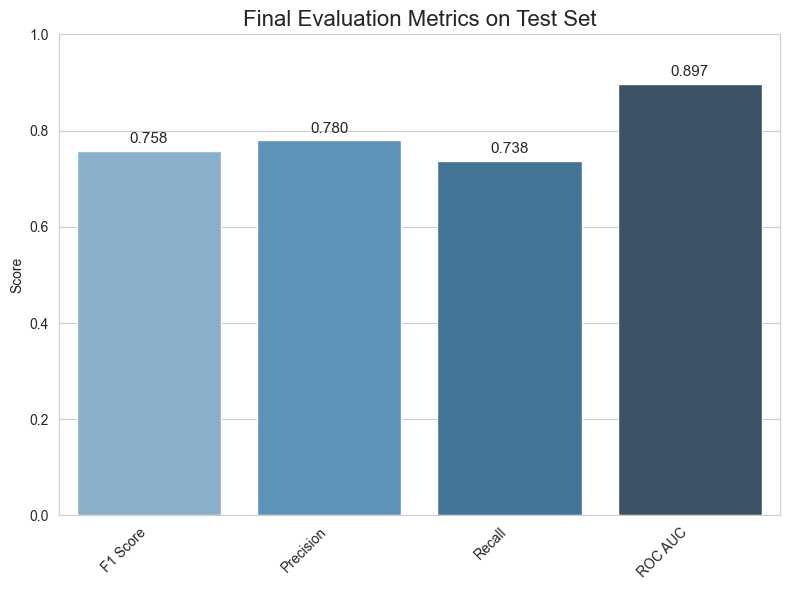

In [28]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Final Evaluation Metrics on Test Set", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

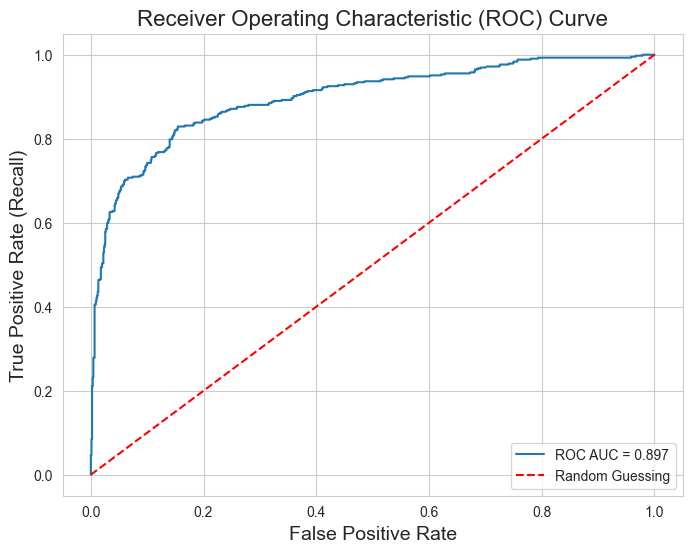

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate (Recall)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

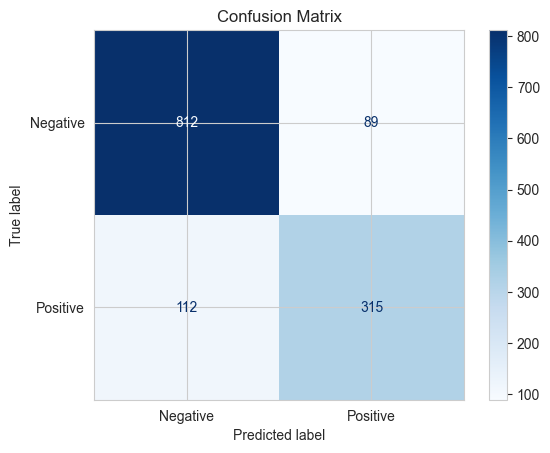

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = best_pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()